In [1]:
# --- Config
from pathlib import Path
MODEL_PATH = Path.home() / "/Users/vkhawarey/Documents/research/models/qwen2.5-7b-instruct-q4_k_m-00001-of-00002.gguf"
NLI_REPO   = "MoritzLaurer/deberta-v3-base-zeroshot-v1"  # small, public, 2-class

TOPK_LIST  = [2, 4, 8]
RANDOM_SEED = 42

# --- Imports
import os, time, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt; import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import faiss

from llama_cpp import Llama
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [2]:
def set_seed(seed=RANDOM_SEED):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed)
    try:
        torch.manual_seed(seed)
    except Exception:
        pass

class Timer:
    def __enter__(self): self.t0 = time.time(); return self
    def __exit__(self, *args): self.dt = time.time() - self.t0
set_seed()

In [3]:
def clean_texts(texts):
    out = []
    for t in texts:
        t = re.sub(r"\s+", " ", str(t)).strip()
        out.append(t)
    return out
def build_retrievers(corpus):
    corpus = clean_texts(corpus)

    # TF-IDF
    tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = tfidf.fit_transform(corpus)

    # Dense (MiniLM)
    dense_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    emb = dense_model.encode(corpus, normalize_embeddings=True, batch_size=256, show_progress_bar=False)
    index = faiss.IndexFlatIP(emb.shape[1]); index.add(emb.astype(np.float32))

    return tfidf, tfidf_matrix, dense_model, index, corpus

def dense_search(query, dense_model, index, k):
    qv = dense_model.encode([query], normalize_embeddings=True)
    sims, idx = index.search(qv.astype(np.float32), k)
    return idx[0].tolist()

def load_llama(model_path):
    return Llama(
        model_path=str(model_path),
        n_ctx=4096,
        n_threads=6,
        n_batch=256,
        use_mlock=True,
        logits_all=True,    # capture probabilities if available (version-dependent)
        verbose=False
    )

LLM = load_llama(MODEL_PATH)

SYS = "You are a cybersecurity analyst. Answer concisely and cite facts from the provided context."
def make_prompt(query, ctx_chunks):
    ctx = "\n\n".join(ctx_chunks)
    return f"""[SYSTEM]\n{SYS}\n[/SYSTEM]\n[CONTEXT]\n{ctx}\n[/CONTEXT]\n[QUESTION]\n{query}\n[/QUESTION]\n[ANSWER]"""

def rag_generate(query, corpus, idxs, max_tokens=180, temperature=0.7):
    ctx_chunks = [corpus[i] for i in idxs]
    prompt = make_prompt(query, ctx_chunks)
    out = LLM(prompt, max_tokens=max_tokens, temperature=temperature, logprobs=1, stop=["[/ANSWER]", "\n\n"])
    text = out["choices"][0]["text"].strip()
    return text, ctx_chunks

llama_context: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

In [4]:
# Cache NLI locally (optional)
local_nli = os.path.expanduser("~/Documents/research/models/deberta-v3-base-zeroshot-v1")
if not os.path.exists(local_nli):
    snapshot_download(NLI_REPO, local_dir=local_nli, local_dir_use_symlinks=False)

tok = AutoTokenizer.from_pretrained(local_nli, local_files_only=True)
nli = AutoModelForSequenceClassification.from_pretrained(local_nli, local_files_only=True)
device = "mps" if torch.backends.mps.is_available() else "cpu"
nli.to(device); nli.eval()

def split_sents(text):
    s = re.split(r'(?<=[.!?])\s+', text.strip())
    return [x for x in s if len(x.split()) >= 5]

@torch.inference_mode()
def nli_probs(premises, hypothesis):
    if not premises: return np.array([0.0]), np.array([0.0])
    pairs = [(p, hypothesis) for p in premises]
    enc = tok(pairs, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    logits = nli(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    if probs.shape[1] == 3:       # MNLI
        p_con, p_neu, p_ent = probs[:,0], probs[:,1], probs[:,2]
    elif probs.shape[1] == 2:     # 2-class zero-shot
        p_con, p_ent = probs[:,0], probs[:,1]; p_neu = np.zeros_like(p_con)
    else:
        raise ValueError(f"Unexpected NLI shape {probs.shape}")
    return p_ent, p_con

def claim_support(summary, context_chunks, tau_s=0.7, tau_x=0.5):
    claims = split_sents(summary)
    if not claims:
        return {"GECS":0.0, "P_g":0.0, "H":1.0, "X":0.0, "n_claims":0}
    U = []; good=[]; hall=[]; contra=[]
    for c in claims:
        p_ent, p_con = nli_probs(context_chunks, c)
        s_i, x_i = float(np.max(p_ent)), float(np.max(p_con))
        u_i = max(0.0, s_i - x_i)
        U.append(u_i)
        good.append((s_i>=tau_s) and (x_i<tau_x))
        hall.append(s_i<tau_s)
        contra.append(x_i>=tau_x)
    U = np.array(U, dtype=float)
    return {
        "GECS": float(U.mean()),
        "P_g": float(np.mean(good)),
        "H":   float(np.mean(hall)),
        "X":   float(np.mean(contra)),
        "n_claims": len(claims)
    }

/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [5]:
def evaluate_query(query, corpus, tfidf, tfidf_matrix, dense_model, index, top_k):
    # dense retrieval
    idxs = dense_search(query, dense_model, index, top_k)
    summary, ctx = rag_generate(query, corpus, idxs)
    scores = claim_support(summary, ctx)
    return {
        "query": query,
        "top_k": top_k,
        "summary": summary,
        "context": ctx,
        **scores
    }

def run_experiment(dataset_name, corpus, queries, topk_list=TOPK_LIST):
    tfidf, tfidf_matrix, dense_model, index, corpus = build_retrievers(corpus)
    rows = []
    for q in tqdm(queries, desc=f"{dataset_name}"):
        for k in topk_list:
            with Timer() as T:
                res = evaluate_query(q, corpus, tfidf, tfidf_matrix, dense_model, index, k)
            res.update({"dataset": dataset_name, "latency": T.dt})
            rows.append(res)
    return pd.DataFrame(rows)

In [46]:
def plot_fig4(df_exp, name, outdir="."):
    os.makedirs(outdir, exist_ok=True)
    df_summary = df_exp.groupby("top_k", as_index=False).agg(
        GECS_mean=("GECS","mean"),
        GECS_std=("GECS","std"),
        Lat_mean=("latency","mean"),
        Lat_std=("latency","std")
    )
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 3, figsize=(14,4))

    sns.lineplot(x="top_k", y="GECS_mean", data=df_summary,
                 marker="o", ax=axes[0], color="#4C72B0")
    axes[0].fill_between(df_summary["top_k"],
                         df_summary["GECS_mean"]-df_summary["GECS_std"],
                         df_summary["GECS_mean"]+df_summary["GECS_std"],
                         color="#4C72B0", alpha=0.2)
    axes[0].set_title("(a) Mean GECS vs Retrieval Depth"); axes[0].set_ylim(0,1.05)
    axes[0].set_xlabel("top-k"); axes[0].set_ylabel("GECS")

    sns.boxplot(x="top_k", y="GECS", data=df_exp, ax=axes[1], palette="Blues", width=0.5)
    sns.stripplot(x="top_k", y="GECS", data=df_exp, ax=axes[1], color="black", size=3, jitter=True)
    axes[1].set_title("(b) Per-Query GECS Distribution"); axes[1].set_ylim(0,1.05)
    axes[1].set_xlabel("top-k"); axes[1].set_ylabel("GECS")

    sns.lineplot(x="top_k", y="Lat_mean", data=df_summary, ax=axes[2], marker="o", color="#55A868")
    axes[2].fill_between(df_summary["top_k"],
                         df_summary["Lat_mean"]-df_summary["Lat_std"],
                         df_summary["Lat_mean"]+df_summary["Lat_std"],
                         color="#55A868", alpha=0.2)
    axes[2].set_title("(c) Latency vs Retrieval Depth"); axes[2].set_xlabel("top-k"); axes[2].set_ylabel("Seconds")

    plt.tight_layout(); path = os.path.join(outdir, f"fig4_gecs_latency_three_panel_{name}.png")
    plt.savefig(path, dpi=300, bbox_inches="tight"); plt.show()
    print("Saved:", path)

In [7]:
def plot_fig6_clean(df_uncert, outdir="figures"):
    os.makedirs(outdir, exist_ok=True)
    df_uncert = df_uncert.copy()
    df_uncert["entropy_drop"] = df_uncert["entropy_null"] - df_uncert["entropy_full"]

    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 2, figsize=(9,3))

    sns.barplot(x="query", y="entropy_drop", data=df_uncert, color="#4C72B0", ax=axes[0])
    axes[0].set_ylabel("Entropy Drop (No-ctx − Ctx)")
    axes[0].set_title("(a) Entropy Reduction per Query")
    axes[0].tick_params(axis='x', rotation=25)

    sns.barplot(x="query", y="retrieval_JS", data=df_uncert, color="#55A868", ax=axes[1])
    axes[1].set_ylabel("JS Divergence")
    axes[1].set_title("(b) Retrieval Sensitivity per Query")
    axes[1].tick_params(axis='x', rotation=25)

    plt.tight_layout(); path = os.path.join(outdir, "fig6_internal_uncertainty_clean.png")
    plt.savefig(path, dpi=300, bbox_inches="tight"); plt.show()
    print("Saved:", path)

In [13]:
import json
with open("data/enterprise-attack-17.1.json") as f:
    data = json.load(f)

records = []
for obj in data["objects"]:
    if obj.get("type") == "attack-pattern":
        records.append({
            "id": obj.get("external_references", [{}])[0].get("external_id", ""),
            "name": obj.get("name", ""),
            "text": obj.get("description", "")
        })

df_mitre = pd.DataFrame(records).dropna(subset=["text"])
corpus_mitre = df_mitre["text"].tolist()
print(f"✅ Loaded {len(corpus_mitre)} MITRE ATT&CK techniques.")

✅ Loaded 823 MITRE ATT&CK techniques.


/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
MITRE: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [04:31<00:00, 54.35s/it]
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_98820/3926320384.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="top_k", y="GECS", data=df_exp, ax=axes[1], palette="Blues", width=0.5)


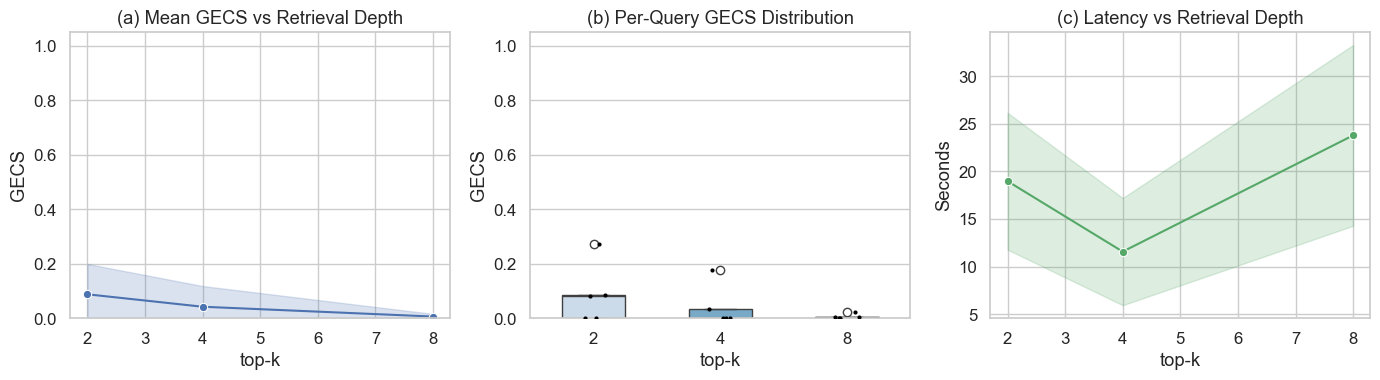

Saved: figures/fig4_gecs_latency_three_panel.png


In [15]:
queries_mitre = [
    "Privilege escalation via scripting interpreters",
    "Command and control using PowerShell",
    "Persistence through scheduled tasks",
    "Credential dumping from LSASS memory",
    "Defense evasion through obfuscated files or information",
]
df_mitre = run_experiment("MITRE", corpus_mitre, queries_mitre, TOPK_LIST)


/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_98820/44464590.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="top_k", y="GECS", data=df_exp, ax=axes[1], palette="Blues", width=0.5)


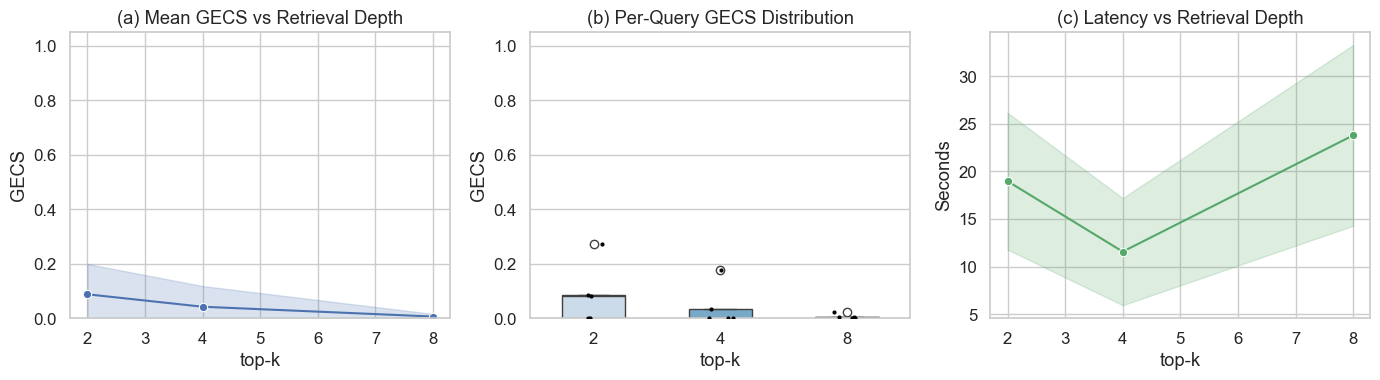

Saved: ./fig4_gecs_latency_three_panel_mitre.png


In [47]:
plot_fig4(df_mitre, "mitre")

In [39]:
def load_nvd_corpus(json_path):
    """
    Load NVD CVE JSON 2.0 feed (2023+) and return a cleaned corpus and DataFrame.
    Each record: id, text, year.
    """
    json_path = Path(json_path)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # The key changed from 'CVE_Items' to 'vulnerabilities'
    items = data.get("vulnerabilities", [])
    if not items:
        raise ValueError(f"No 'vulnerabilities' field found in {json_path.name}")

    records = []
    for entry in items:
        cve_obj = entry.get("cve", {})
        cve_id = cve_obj.get("id", "")
        descs = cve_obj.get("descriptions", [])
        text = ""
        for d in descs:
            if d.get("lang") == "en" and d.get("value"):
                text = d["value"].strip()
                break
        if not text:
            continue

        year = cve_id.split("-")[1] if "-" in cve_id else ""
        records.append({"id": cve_id, "text": text, "year": year})

    if not records:
        raise ValueError(f"No valid CVE descriptions found in {json_path.name}")

    df = pd.DataFrame.from_records(records)
    df = df.dropna(subset=["text"]).drop_duplicates(subset=["text"])
    corpus = df["text"].tolist()

    print(f"✅ Loaded {len(corpus)} CVE entries from {json_path.name}")
    return corpus, df

In [40]:
corpus_nvd, df_nvd = load_nvd_corpus("data/nvdcve-2.0-2025.json")

✅ Loaded 28922 CVE entries from nvdcve-2.0-2025.json


In [41]:
df_nvd_results = run_experiment("NVD", corpus_nvd, queries_mitre, TOPK_LIST)

/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
NVD: 100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [04:43<00:00, 56.61s/it]


/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_98820/44464590.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="top_k", y="GECS", data=df_exp, ax=axes[1], palette="Blues", width=0.5)


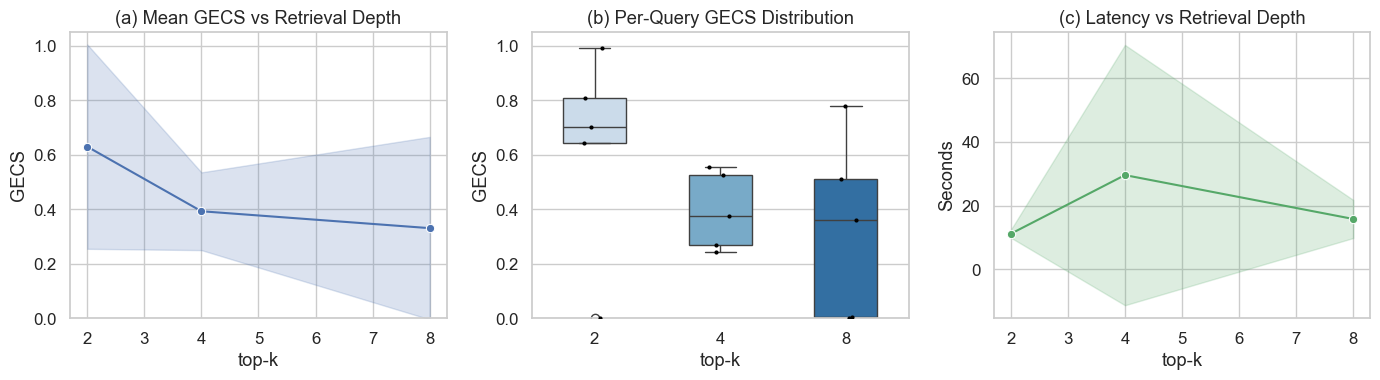

Saved: ./fig4_gecs_latency_three_panel_nvd.png


In [48]:
plot_fig4(df_nvd_results, "nvd")

In [57]:
def plot_fig4_two_panel_comparative(df_nvd, df_mitre, outdir="."):
    """
    Comparative 2-panel plot showing:
      (a) Mean GECS (Factual Consistency) vs Retrieval Depth
      (b) Latency vs Retrieval Depth
    for NVD and MITRE datasets.
    Compact IEEE-ready layout with non-overlapping legend.
    """
    import os, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
    os.makedirs(outdir, exist_ok=True)

    def summarize(df, name):
        df = df.groupby("top_k", as_index=False).agg(
            GECS_mean=("GECS", "mean"),
            GECS_std=("GECS", "std"),
            Lat_mean=("latency", "mean"),
            Lat_std=("latency", "std"),
        )
        df["dataset"] = name
        return df

    # Combine and ensure ordering
    df_summary = pd.concat(
        [summarize(df_nvd, "NVD"), summarize(df_mitre, "MITRE")],
        ignore_index=True
    ).sort_values(by=["dataset", "top_k"])

    # --- Style ---
    sns.set(style="whitegrid", font_scale=1.05)
    palette = {"NVD": "#4C72B0", "MITRE": "#DD8452"}

    fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.3))

    # --- Panel (a): GECS vs Retrieval Depth ---
    sns.lineplot(
        data=df_summary, x="top_k", y="GECS_mean",
        hue="dataset", style="dataset", markers=True,
        dashes=False, palette=palette, ax=axes[0],
        lw=1.8
    )

    for dataset, sub in df_summary.groupby("dataset"):
        axes[0].fill_between(
            sub["top_k"],
            sub["GECS_mean"] - sub["GECS_std"],
            sub["GECS_mean"] + sub["GECS_std"],
            color=palette[dataset], alpha=0.15,
        )

    axes[0].set_title("(a) Factual Consistency")
    axes[0].set_xlabel("Retrieval Depth (top-k)")
    axes[0].set_ylabel("Mean GECS")
    axes[0].set_xticks(sorted(df_summary["top_k"].unique()))
    axes[0].set_ylim(0, 1.0)

    # Move legend outside the plot (above both panels)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, title="Dataset",
        loc="upper center", ncol=2, frameon=True,
        bbox_to_anchor=(0.5, 1.12)
    )
    axes[0].get_legend().remove()

    # --- Panel (b): Latency vs Retrieval Depth ---
    sns.lineplot(
        data=df_summary, x="top_k", y="Lat_mean",
        hue="dataset", style="dataset", markers=True,
        dashes=False, palette=palette, ax=axes[1],
        lw=1.8
    )

    for dataset, sub in df_summary.groupby("dataset"):
        axes[1].fill_between(
            sub["top_k"],
            sub["Lat_mean"] - sub["Lat_std"],
            sub["Lat_mean"] + sub["Lat_std"],
            color=palette[dataset], alpha=0.15,
        )

    axes[1].set_title("(b) Latency")
    axes[1].set_xlabel("Retrieval Depth (top-k)")
    axes[1].set_ylabel("Seconds")
    axes[1].set_xticks(sorted(df_summary["top_k"].unique()))
    axes[1].get_legend().remove()

    plt.tight_layout()
    path = os.path.join(outdir, "fig4_gecs_latency_two_panel_comparative.png")
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", path)

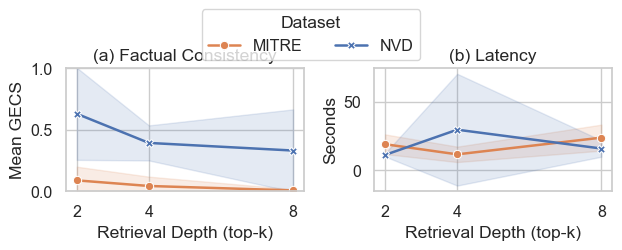

✅ Saved: ./fig4_gecs_latency_two_panel_comparative.png


In [58]:
plot_fig4_two_panel_comparative(df_nvd_results, df_mitre)

In [67]:
def adaptive_rag(
    query,
    corpus,
    tfidf=None, tfidf_matrix=None, dense_model=None, index=None,
    k_options=(2, 4, 8),
    lambda_cost=0.02,
    eps_gain=0.02,
    max_seconds=30
):
    import time

    # 🔹 build retrievers if not provided
    if tfidf is None or dense_model is None:
        tfidf, tfidf_matrix, dense_model, index, corpus = build_retrievers(corpus)

    logs = []
    best_k, best_J, best_gecs = None, -1e9, 0.0
    t_start = time.time()

    for k in sorted(k_options):
        t0 = time.time()
        res = evaluate_query(query, corpus, tfidf, tfidf_matrix, dense_model, index, k)
        gecs = res["GECS"]
        latency = time.time() - t0
        total_latency = time.time() - t_start
        J = gecs - lambda_cost * total_latency
        logs.append({"k": k, "GECS": gecs, "latency": latency, "J": J})

        if best_k is not None and ((gecs - best_gecs) < eps_gain or total_latency > max_seconds):
            break

        if J > best_J:
            best_k, best_J, best_gecs = k, J, gecs

    final = evaluate_query(query, corpus, tfidf, tfidf_matrix, dense_model, index, best_k)
    final.update({
        "k_star": best_k,
        "J": best_J,
        "latency_total": time.time() - t_start,
        "policy": "adaptive",
        "logs": logs
    })
    return final

In [68]:

def run_adaptive_experiment(dataset_name, corpus, queries):
    """
    Runs GECS-guided adaptive retrieval for all queries.
    Mirrors run_experiment() structure for easy comparison.
    """
    tfidf, tfidf_matrix, dense_model, index, corpus = build_retrievers(corpus)
    rows = []

    for q in tqdm(queries, desc=f"{dataset_name}-adaptive"):
        with Timer() as T:
            res = adaptive_rag(q, corpus, tfidf, tfidf_matrix, dense_model, index)
        res.update({
            "dataset": dataset_name,
            "latency": T.dt,
            "policy": "adaptive",
        })
        rows.append(res)

    return pd.DataFrame(rows)

In [62]:
adaptive_results_mitre = [adaptive_rag(q, corpus_mitre) for q in queries_mitre]

/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [64]:
queries_nvd = queries_mitre

In [69]:
adaptive_results_nvd = run_adaptive_experiment("NVD", corpus_nvd, queries_nvd)

NVD-adaptive: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.77s/it]


In [76]:
(
    adaptive_results_nvd
    .groupby("top_k", as_index=False)
    .agg(
        GECS_mean=("GECS", "mean"),
        latency_mean=("latency_total", "mean"),
        J_mean=("J", "mean")
    )
)


,top_k,GECS_mean,latency_mean,J_mean
0,2,0.596991,39.764093,0.405685


In [85]:
lambda_cost = 0.02
df_nvd_results["J"] = df_nvd_results['GECS'] - lambda_cost * df_nvd_results["latency"]
(
    df_nvd_results
    .groupby("top_k", as_index=False)
    .agg(
        GECS_mean=("GECS", "mean"),
        latency_mean=("latency", "mean"),
        J_mean=("J", "mean")
    )
)

,top_k,GECS_mean,latency_mean,J_mean
0,2,0.629282,11.188612,0.405510
1,4,0.392425,29.597685,-0.199529
2,8,0.330418,15.827007,0.013878


In [87]:
df_mitre["J"] = df_mitre['GECS'] - lambda_cost * df_mitre["latency"]
(
    df_mitre
    .groupby("top_k", as_index=False)
    .agg(
        GECS_mean=("GECS", "mean"),
        latency_mean=("latency", "mean"),
        J_mean=("J", "mean")
    )
)

,top_k,GECS_mean,latency_mean,J_mean
0,2,0.087849,18.978012,-0.291711
1,4,0.042236,11.576611,-0.189296
2,8,0.006248,23.793020,-0.469612


In [84]:
pd_mitre_adapt_tmp = pd.DataFrame(adaptive_results_mitre)
(
    pd_mitre_adapt_tmp
    .groupby("top_k", as_index=False)
    .agg(
        GECS_mean=("GECS", "mean"),
        latency_mean=("latency_total", "mean"),
        J_mean=("J", "mean")
    )
)

,top_k,GECS_mean,latency_mean,J_mean
0,2,0.115354,37.021908,-0.253403


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def plot_decision_trajectories(nvd_data, mitre_data, outdir=".", save=True, show_J=False):
    """
    Compare adaptive retrieval agent decision trajectories for NVD and MITRE datasets.
    nvd_data, mitre_data : list[list[dict]]
        Each inner list represents a query trace: [{k, GECS, latency, J}, ...]
    outdir : str
        Directory to save output figure.
    save : bool
        Whether to save the figure.
    show_J : bool
        If True, overlay the utility J(k) curve as dashed red line.
    """

    os.makedirs(outdir, exist_ok=True)

    def aggregate_trace(dataset):
        """Flatten and compute mean + std per retrieval depth."""
        df = pd.DataFrame([d for q in dataset for d in q])
        return (
            df.groupby("k", as_index=False)
              .agg(GECS_mean=("GECS", "mean"),
                   GECS_std=("GECS", "std"),
                   Lat_mean=("latency", "mean"),
                   Lat_std=("latency", "std"),
                   J_mean=("J", "mean"))
        )

    # Aggregate both datasets
    df_nvd, df_mitre = aggregate_trace(nvd_data), aggregate_trace(mitre_data)

    sns.set(style="whitegrid", font_scale=1.0)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.2))

    def plot_panel(ax, df, title, ylim=None):
        """Helper to draw one dataset panel."""
        # --- Primary (GECS) axis ---
        sns.lineplot(x="k", y="GECS_mean", data=df, marker="o", color="#4C72B0",
                     linewidth=1.8, ax=ax, label="GECS (Factuality)")
        ax.fill_between(df["k"],
                        df["GECS_mean"] - df["GECS_std"],
                        df["GECS_mean"] + df["GECS_std"],
                        color="#4C72B0", alpha=0.1)
        ax.set_ylabel("GECS (Factuality)", color="#4C72B0")
        ax.tick_params(axis='y', labelcolor="#4C72B0")
        if ylim:
            ax.set_ylim(*ylim)

        # --- Secondary (Latency) axis ---
        ax2 = ax.twinx()
        sns.lineplot(x="k", y="Lat_mean", data=df, marker="s", color="#55A868",
                     linewidth=1.8, ax=ax2, label="Latency (s)")
        ax2.fill_between(df["k"],
                         df["Lat_mean"] - df["Lat_std"],
                         df["Lat_mean"] + df["Lat_std"],
                         color="#55A868", alpha=0.1)
        ax2.set_ylabel("Latency (s)", color="#55A868")
        ax2.tick_params(axis='y', labelcolor="#55A868")

        # --- Optional J(k) overlay ---
        if show_J:
            ax3 = ax.twinx()
            ax3.spines["right"].set_position(("outward", 40))
            sns.lineplot(x="k", y="J_mean", data=df, color="crimson",
                         linestyle="--", linewidth=1.4, ax=ax3, label="Utility J(k)")
            ax3.set_ylabel("Utility J(k)", color="crimson")
            ax3.tick_params(axis='y', labelcolor="crimson")

        # --- Decision line ---
        k_star = df.loc[df["J_mean"].idxmax(), "k"]
        ax.axvline(k_star, ls="--", color="gray", lw=1.2)
        ax.text(k_star + 0.05, df["GECS_mean"].max() * 0.85,
                rf"$k^* = {int(k_star)}$", color="gray", fontsize=9, alpha=0.6)

        # --- Title, axis labels ---
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("Retrieval Depth (top-k)")

        # --- Compact legends ---
        handles, labels = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        if show_J:
            handles3, labels3 = ax3.get_legend_handles_labels()
            handles += handles2 + handles3
            labels += labels2 + labels3
        else:
            handles += handles2
            labels += labels2
        ax.legend(handles, labels, loc="upper left", fontsize=9, frameon=True, edgecolor='0.8')

    # --- Draw both panels ---
    plot_panel(axes[0], df_nvd, "(a) NVD (Structured)", ylim=(0.3, 1.0))
    plot_panel(axes[1], df_mitre, "(b) MITRE (Semi-Structured)", ylim=(-0.02, 0.12))

    plt.tight_layout()
    if save:
        path = os.path.join(outdir, "fig7_decision_trajectory_comparative_clean.png")
        plt.savefig(path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved figure to: {path}")
    plt.show()

    return df_nvd, df_mitre

✅ Saved figure to: ./fig7_decision_trajectory_comparative_clean.png


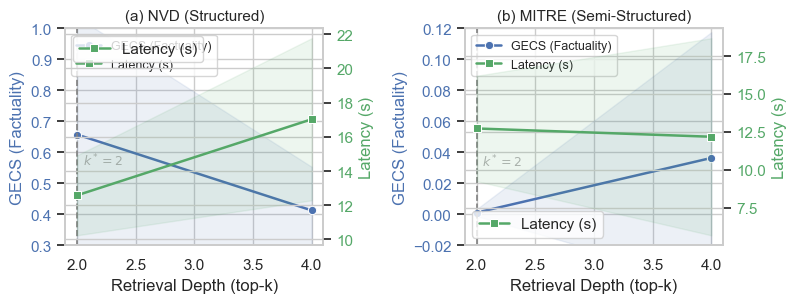

(   k  GECS_mean  GECS_std   Lat_mean   Lat_std    J_mean
 0  2   0.657241  0.379376  12.577818  2.338279  0.405685
 1  4   0.412206  0.140678  17.030307  4.741381 -0.179957,
    k  GECS_mean  GECS_std   Lat_mean   Lat_std    J_mean
 0  2   0.000992  0.002217  12.719722  3.476005 -0.253403
 1  4   0.036313  0.081199  12.172879  6.505699 -0.461539)

In [114]:
plot_decision_trajectories(nvd_data=list(pd.DataFrame(adaptive_results_nvd)["logs"]), mitre_data=list(pd.DataFrame(adaptive_results_mitre)["logs"]), show_J=False)